<a href="https://colab.research.google.com/github/RMottram/2D-CNN/blob/master/Network_signals_dnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Oct 21 12:30:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# !unzip /content/drive/MyDrive/Colab\ Notebooks/64x64.zip > /dev/null
# !unzip /content/drive/MyDrive/Colab\ Notebooks/32x32.zip > /dev/null
# !unzip /content/drive/MyDrive/Colab\ Notebooks/split_images.zip > /dev/null
!unzip /content/drive/MyDrive/Colab\ Notebooks/datasets_V2.zip > /dev/null

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imblearn, sys, os, time
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
# from sklearn.compose import ColumnTransformer
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
# from keras.utils import to_categorical
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

# Settings
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.5f}'.format
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=3)

In [15]:
## 80/20
normal_train = pd.read_csv('/content/v2/normal_train_8020_raw.csv')
normal_test = pd.read_csv('/content/v2/normal_test_8020_raw.csv')
ip_train = pd.read_csv('/content/v2/ip_train_8020_raw.csv')
ip_test = pd.read_csv('/content/v2/ip_test_8020_raw.csv')
port_train = pd.read_csv('/content/v2/port_train_8020_raw.csv')
port_test = pd.read_csv('/content/v2/port_test_8020_raw.csv')

## 70/30
# normal_train = pd.read_csv('/content/v2/normal_train_7030.csv')
# normal_test = pd.read_csv('/content/v2/normal_test_7030.csv')
# ip_train = pd.read_csv('/content/v2/ip_train_7030.csv')
# ip_test = pd.read_csv('/content/v2/ip_test_7030.csv')
# port_train = pd.read_csv('/content/v2/port_train_7030.csv')
# port_test = pd.read_csv('/content/v2/port_test_7030.csv')

## 60/40
# normal_train = pd.read_csv('/content/v2/normal_train_6040.csv')
# normal_test = pd.read_csv('/content/v2/normal_test_6040.csv')
# ip_train = pd.read_csv('/content/v2/ip_train_6040.csv')
# ip_test = pd.read_csv('/content/v2/ip_test_6040.csv')
# port_train = pd.read_csv('/content/v2/port_train_6040.csv')
# port_test = pd.read_csv('/content/v2/port_test_6040.csv')


In [ ]:
normal_train.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,icmp,tcp,udp,IRC,X11,Z39_50,auth,bgp,courier,csnet_ns,ctf,daytime,discard,domain,domain_u,echo,eco_i,ecr_i,efs,exec,finger,ftp,ftp_data,gopher,hostnames,http,http_443,imap4,iso_tsap,klogin,kshell,ldap,link,login,mtp,name,netbios_dgm,netbios_ns,netbios_ssn,netstat,nnsp,nntp,ntp_u,other,pm_dump,pop_2,pop_3,private,remote_job,shell,smtp,sql_net,ssh,sunrpc,supdup,systat,telnet,tftp_u,tim_i,time,urp_i,uucp,uucp_path,vmnet,whois,OTH,REJ,RSTO,RSTOS0,RSTR,S0,S1,S2,S3,SF,SH,attack_type
0,0.00000,0.00001,0.00001,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,66.86888,106.79061,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,2.55000,255.00000,254.00000,255.00000,2.55000,2.55000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,normal
1,0.00000,0.00005,0.00013,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,5.98826,6.98630,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,35.70000,68.00000,255.00000,255.00000,0.00000,2.55000,5.10000,0.00000,0.00000,0.00000,2.55000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,normal
2,0.13255,0.00001,0.00001,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.49706,2.99413,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,84.15000,255.00000,240.00000,239.70000,5.10000,15.30000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,normal
3,0.00000,0.00006,0.00277,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0

In [16]:
## merging the appropriate datasets together
normal_ip_train = normal_train.append(ip_train)
normal_ip_test = normal_test.append(ip_test)

normal_port_train = normal_train.append(port_train)
normal_port_test = normal_test.append(port_test)

ip_port_train = ip_train.append(port_train)
ip_port_test = ip_test.append(port_test)

In [ ]:
normal_ip_train

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,icmp,tcp,udp,IRC,X11,Z39_50,auth,bgp,courier,csnet_ns,ctf,daytime,discard,domain,domain_u,echo,eco_i,ecr_i,efs,exec,finger,ftp,ftp_data,gopher,hostnames,http,http_443,imap4,iso_tsap,klogin,kshell,ldap,link,login,mtp,name,netbios_dgm,netbios_ns,netbios_ssn,netstat,nnsp,nntp,ntp_u,other,pm_dump,pop_2,pop_3,private,remote_job,shell,smtp,sql_net,ssh,sunrpc,supdup,systat,telnet,tftp_u,tim_i,time,urp_i,uucp,uucp_path,vmnet,whois,OTH,REJ,RSTO,RSTOS0,RSTR,S0,S1,S2,S3,SF,SH,attack_type
0,0.00000,0.00001,0.00001,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,66.86888,106.79061,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,2.55000,255.00000,254.00000,255.00000,2.55000,2.55000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,normal
1,0.00000,0.00005,0.00013,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,5.98826,6.98630,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,35.70000,68.00000,255.00000,255.00000,0.00000,2.55000,5.10000,0.00000,0.00000,0.00000,2.55000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,normal
2,0.13255,0.00001,0.00001,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.49706,2.99413,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,84.15000,255.00000,240.00000,239.70000,5.10000,15.30000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,normal
3,0.00000,0.00006,0.00277,0.00000,0.00000,0.00000,0.00000,0.00000,255.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0

In [17]:
normal_ip_train_class = pd.Series(normal_ip_train.iloc[:,-1])
normal_ip_test_class = pd.Series(normal_ip_test.iloc[:,-1])

normal_port_train_class = pd.Series(normal_port_train.iloc[:,-1])
normal_port_test_class = pd.Series(normal_port_test.iloc[:,-1])

ip_port_train_class = pd.Series(ip_port_train.iloc[:,-1])
ip_port_test_class = pd.Series(ip_port_test.iloc[:,-1])

In [11]:
normal_ip_train_class

pd.get_dummies(ip_port_train_class)

,ipsweep,portsweep
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
63893,0,1
63894,0,1
63895,0,1
63896,0,1


In [18]:
normal_ip_train = normal_ip_train.drop(['attack_type'], axis = 1)
normal_ip_test = normal_ip_test.drop(['attack_type'], axis = 1)

normal_port_train = normal_port_train.drop(['attack_type'], axis = 1)
normal_port_test = normal_port_test.drop(['attack_type'], axis = 1)

ip_port_train = ip_port_train.drop(['attack_type'], axis = 1)
ip_port_test = ip_port_test.drop(['attack_type'], axis = 1)

In [19]:
## shuffle the data to prevent pattern recognition
normal_ip_train, normal_ip_train_class = sklearn.utils.shuffle(normal_ip_train, normal_ip_train_class, random_state = 42)
normal_port_train, normal_port_train_class = sklearn.utils.shuffle(normal_port_train, normal_port_train_class, random_state = 42)

normal_ip_test, normal_ip_test_class = sklearn.utils.shuffle(normal_ip_test, normal_ip_test_class, random_state = 42)
normal_port_test, normal_port_test_class = sklearn.utils.shuffle(normal_port_test, normal_port_test_class, random_state = 42)

ip_port_train, ip_port_train_class = sklearn.utils.shuffle(ip_port_train, ip_port_train_class, random_state = 42)
ip_port_test, ip_port_test_class = sklearn.utils.shuffle(ip_port_test, ip_port_test_class, random_state = 42)

In [20]:
ann = Sequential()

## input layer and hidden layer #1
ann.add(Dense(input_dim = 114, units = 10, kernel_initializer = 'uniform', activation = 'relu'))

## hidden layer #2
ann.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))

## hidden layer #3
ann.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'relu'))

## output layer
ann.add(Dense(units = 2, kernel_initializer = 'uniform', activation = 'sigmoid'))

ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# callback = [EarlyStopping(monitor='accuracy', mode='max', patience=3 )]

ann.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                1150      
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 66        
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 28        
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 10        
Total params: 1,254
Trainable params: 1,254
Non-trainable params: 0
_________________________________________________________________


In [60]:
start = time.time()

model_history = ann.fit(ip_port_train, pd.get_dummies(ip_port_train_class), batch_size = 1024, epochs = 120)

end = time.time() - start

print(f'Training for ANN took {round(end,3)} seconds')

Epoch 1/120
254/254 [==============================] - 1s 4ms/step - loss: 6.1609e-04 - accuracy: 0.9998
Epoch 2/120
254/254 [==============================] - 1s 4ms/step - loss: 5.1208e-04 - accuracy: 0.9999
Epoch 3/120
254/254 [==============================] - 1s 4ms/step - loss: 4.6193e-04 - accuracy: 0.9999
Epoch 4/120
254/254 [==============================] - 1s 4ms/step - loss: 4.2390e-04 - accuracy: 0.9999
Epoch 5/120
254/254 [==============================] - 1s 4ms/step - loss: 3.9549e-04 - accuracy: 0.9999
Epoch 6/120
254/254 [==============================] - 1s 4ms/step - loss: 3.6859e-04 - accuracy: 0.9999
Epoch 7/120
254/254 [==============================] - 1s 4ms/step - loss: 3.4356e-04 - accuracy: 0.9999
Epoch 8/120
254/254 [==============================] - 1s 4ms/step - loss: 3.1752e-04 - accuracy: 0.9999
Epoch 9/120
254/254 [==============================] - 1s 4ms/step - loss: 2.9085e-04 - accuracy: 0.9999
Epoch 10/120
254/254 [==============================] -

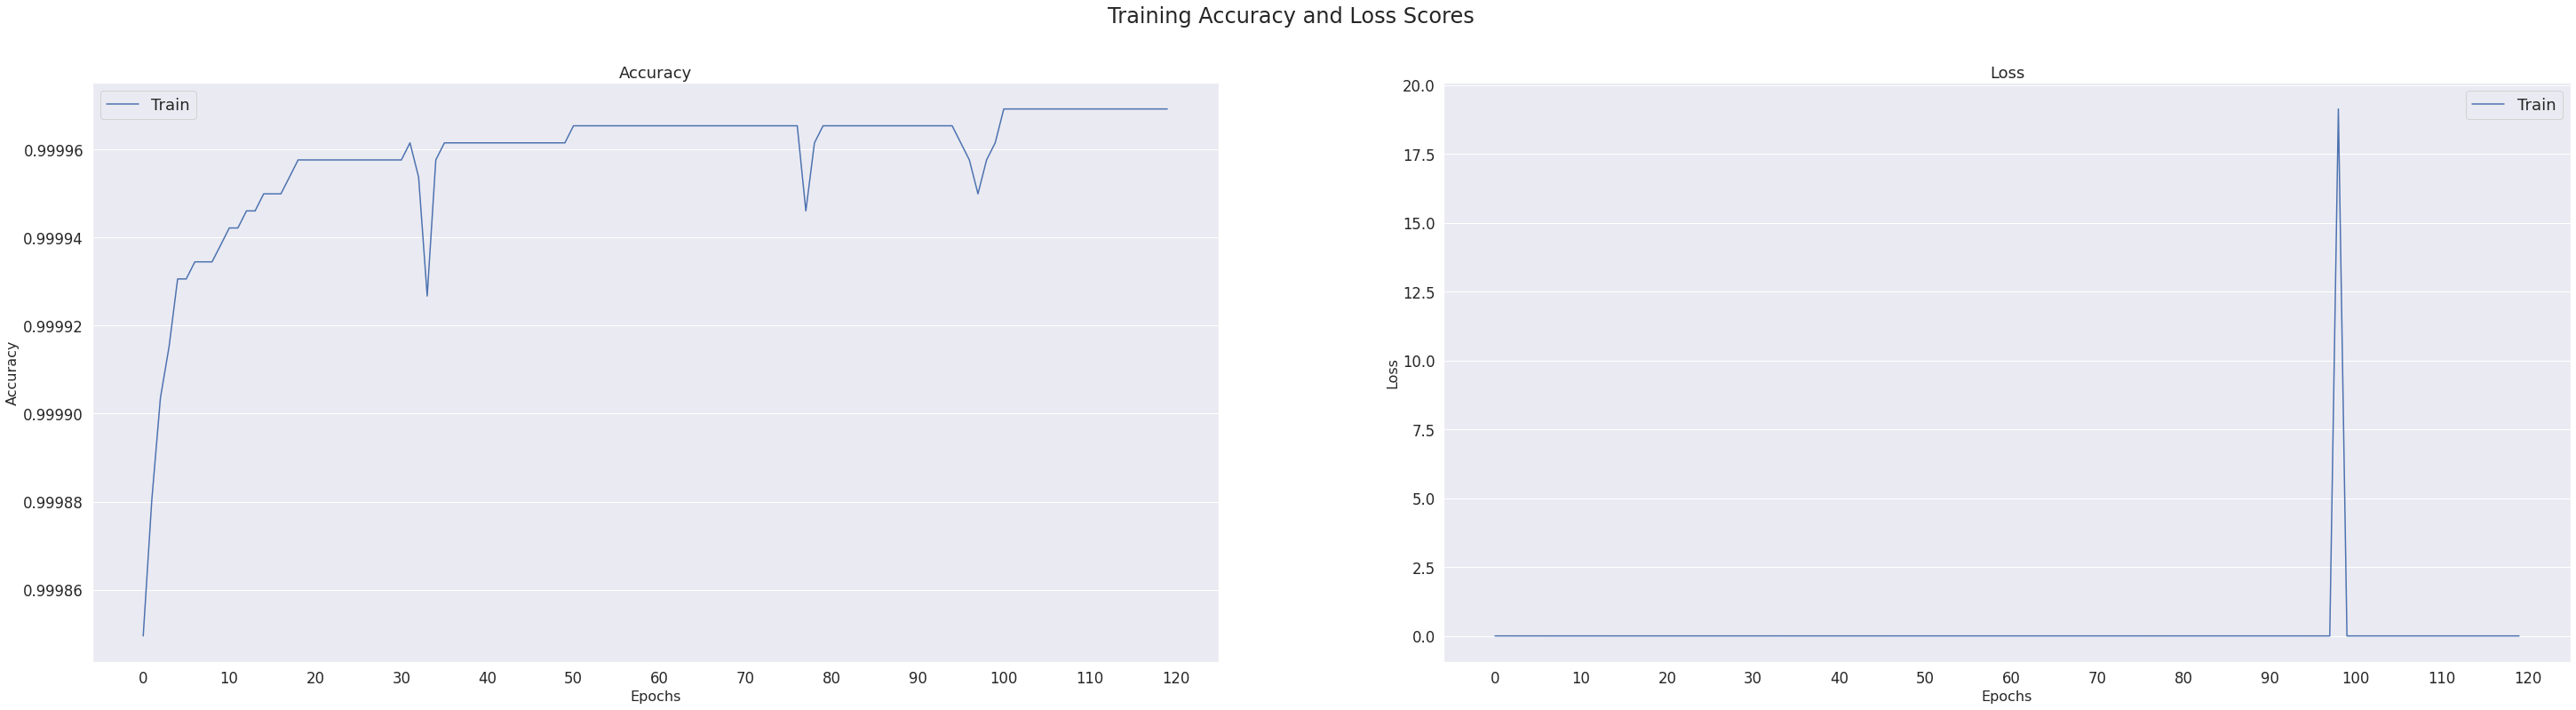

In [61]:
# print(model_history.history.keys())
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(50,12))
fig.suptitle('Training Accuracy and Loss Scores', fontsize = 24)

axes[0].plot(model_history.history['accuracy'])
axes[0].set_title('Accuracy', fontsize = 18)
axes[0].set_ylabel('Accuracy', fontsize = 16)
axes[0].set_xlabel('Epochs', fontsize = 16)
axes[0].set_xticks(np.arange(0, 130, step = 10))
axes[0].grid(axis = 'x')
axes[0].legend(['Train', 'Test'], loc = 'best', fontsize = 18)

axes[1].plot(model_history.history['loss'])
axes[1].set_title('Loss', fontsize = 18)
axes[1].set_ylabel('Loss', fontsize = 16)
axes[1].set_xlabel('Epochs', fontsize = 16)
axes[1].set_xticks(np.arange(0, 130, step = 10))
axes[1].grid(axis = 'x')
axes[1].legend(['Train', 'Test'], loc = 'best', fontsize = 18)

In [62]:
loss, acc = ann.evaluate(ip_port_test, pd.get_dummies(ip_port_test_class), batch_size=1024, verbose=0)
print(f'Loss = {round(loss, 3)}\tAccuracy = {round(acc, 4)*100}%')

Loss = 0.0	Accuracy = 99.99%


In [63]:
preds = (ann.predict(pd.get_dummies(ip_port_test)) > 0.5)

In [64]:
preds

array([[ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [False,  True],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [False,  True],
       [False,  True],
       [ True, False],
       [ True, False],
       [False,  True],
       [ True, False],
       [ True, False],
       [False,  True],
       [ True, False],
       [False,  True],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [False,  True],
       [False,  True],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ True, False],
       [ Tr

In [65]:
def build_classifier():
    
    ann = Sequential()
    ann.add(Dense(input_dim = 114, units = 10, kernel_initializer = 'uniform', activation = 'relu'))
    ann.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
    ann.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
    ann.add(Dense(units = 2, kernel_initializer = 'uniform', activation = 'sigmoid'))
    ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return ann

clf = KerasClassifier(build_fn = build_classifier, batch_size = 1024, epochs = 120)

In [66]:
start = time.time()
from sklearn.model_selection import KFold

kf = KFold(n_splits = 5, random_state = None)
score = cross_val_score(clf, ip_port_test, pd.get_dummies(ip_port_test_class), cv = kf)
print(f'Model Cross Validation Score - {round(score.mean(), 3)*100}%')
print(f'Model Cross Validation Scores - {score}')
print(f'Model Cross Validation standard deviation - {round(score.std(), 3)*100}')
end = time.time() - start


Epoch 1/120
51/51 [==============================] - 1s 4ms/step - loss: 0.8576 - accuracy: 0.7532
Epoch 2/120
51/51 [==============================] - 0s 4ms/step - loss: 2.8907 - accuracy: 0.7548
Epoch 3/120
51/51 [==============================] - 0s 4ms/step - loss: 1.6649 - accuracy: 0.9848
Epoch 4/120
51/51 [==============================] - 0s 4ms/step - loss: 0.4531 - accuracy: 0.9985
Epoch 5/120
51/51 [==============================] - 0s 5ms/step - loss: 0.4284 - accuracy: 0.9986
Epoch 6/120
51/51 [==============================] - 0s 4ms/step - loss: 0.4086 - accuracy: 0.9986
Epoch 7/120
51/51 [==============================] - 0s 5ms/step - loss: 0.3905 - accuracy: 0.9986
Epoch 8/120
51/51 [==============================] - 0s 4ms/step - loss: 0.6705 - accuracy: 0.9987
Epoch 9/120
51/51 [==============================] - 0s 4ms/step - loss: 0.3622 - accuracy: 0.9988
Epoch 10/120
51/51 [==============================] - 0s 4ms/step - loss: 0.3473 - accuracy: 0.9988
Epoch 11/

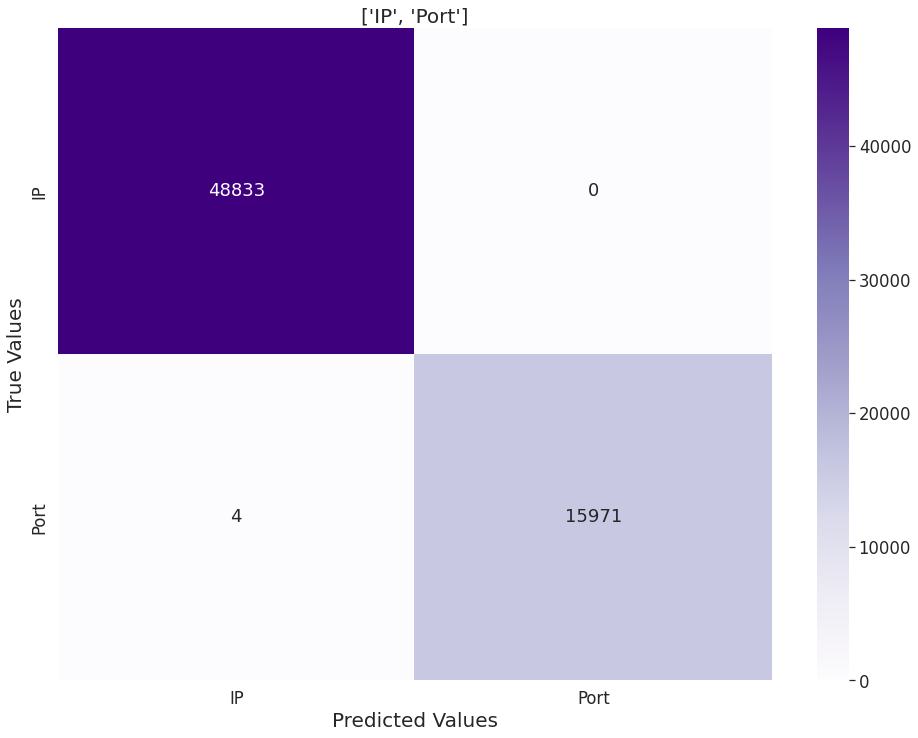

              precision    recall  f1-score   support

          IP       1.00      1.00      1.00     48833
        Port       1.00      1.00      1.00     15975

   micro avg       1.00      1.00      1.00     64808
   macro avg       1.00      1.00      1.00     64808
weighted avg       1.00      1.00      1.00     64808
 samples avg       1.00      1.00      1.00     64808



In [67]:
targets = ['IP', 'Port']
cr = classification_report(pd.get_dummies(ip_port_test_class), preds, target_names=targets, zero_division=0)
cm = confusion_matrix(pd.get_dummies(ip_port_test_class).values.argmax(axis = 1), preds.argmax(axis = 1))

cm_df = pd.DataFrame(cm,
                     index = targets, 
                     columns = targets)


plt.figure(figsize=(16,12))
sns.set(font_scale=1.5)
sns.heatmap(cm_df, annot=True, cmap = 'Purples', fmt='1')
plt.title(targets, fontsize = '20')
plt.ylabel('True Values', fontsize = '20')
plt.xlabel('Predicted Values', fontsize = '20')
plt.show()

print(cr)

In [68]:
def perf_measure(y_actual, y_pred, labels):
    labels = targets
    class_id = set(y_actual).union(set(y_pred))
    TP = []
    FP = []
    TN = []
    FN = []

    for index ,_id in enumerate(class_id):
        TP.append(0)
        FP.append(0)
        TN.append(0)
        FN.append(0)
        for i in range(len(y_pred)):
            if y_actual[i] == y_pred[i] == _id:
                TP[index] += 1
            if y_pred[i] == _id and y_actual[i] != y_pred[i]:
                FP[index] += 1
            if y_actual[i] == y_pred[i] != _id:
                TN[index] += 1
            if y_pred[i] != _id and y_actual[i] != y_pred[i]:
                FN[index] += 1


    return(print(f'{labels}\nTP - {TP}\nFP - {FP}\nTN - {TN}\nFN - {FN}'))


perf_measure(pd.get_dummies(ip_port_test_class).values.argmax(axis = 1), preds.argmax(axis = 1), targets)

['IP', 'Port']
TP - [48833, 15971]
FP - [4, 0]
TN - [15971, 48833]
FN - [0, 4]
